В этом домашнем задании две части:
* в первой части вы попрактикуетесь в использовании различных имплементаций бустинга
* во второй части потренируетесь снижать размерность с помощью метода главных компонент, а также используете методы кластеризации для задач компьютерного зрения

 # Часть 1. Бустинг

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


## Прогнозируем задержки самолётов (3 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми подходами к обработке данных, а также методами градиентного бустинга (XGboost, catboost, LightGBM) и GridSearch для достижения результата. Получите 2 балла за преодоление порога roc_auc_score 0.72 на кросс-валидации и ещё 1 балл за преодоление порога 0.74.

За получение любого значения roc_auc_score < 0.72 (построение модели и вывод на экран некоторого числа) получаете 1 балл.

In [2]:
import pandas as pd

# Загрузка данных
data = pd.read_csv('flight_delays.csv')

# Посмотрим на первые строки датасета
print(data.head())

  Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Загрузка данных
data = pd.read_csv('flight_delays.csv')

# Преобразование категориальных признаков
data = pd.get_dummies(data, columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'])

# Разделение данных на X и y
X = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].map({'N': 0, 'Y': 1})

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели градиентного бустинга
model = GradientBoostingClassifier()

# Подбор гиперпараметров с использованием GridSearch
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Получение наилучших параметров
best_params = grid_search.best_params_

# Обучение модели с лучшими параметрами
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = best_model.predict_proba(X_test)[:, 1]

# Оценка roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("roc_auc_score:", roc_auc)


 # Часть 2. Обучение без учителя.

## Задание 1. Кластеризация (3 балла)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть испоьзован следующий подход: при фиксированной метрики качества для разного числа кластеров вычисляют кластеризацию и выбирают то значение, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации не всегда тривиальная задача, так как следует учитывать такие факты как:
 - объекты одного класса должны быть более похоже, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать абсолютные значения меток объектов, попавших в кластер (в случае, если истинные метоки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

In [14]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import metrics
import numpy as np

# Загрузка данных
digits = load_digits()
X, y = digits.data, digits.target

# Масштабирование данных для улучшения работы KMeans
X = scale(X)

# Перемешивание данных
X, y = shuffle(X, y, random_state=42)

# Выбор числа кластеров с помощью Silhouette Coefficient
range_n_clusters = range(2, 15)  # Примерный диапазон для тестирования
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

# Нахождение оптимального количества кластеров
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
print("Optimal number of clusters:", optimal_n_clusters)


For n_clusters = 2 The average silhouette_score is: 0.1053327053263162
For n_clusters = 3 The average silhouette_score is: 0.10588417396600293
For n_clusters = 4 The average silhouette_score is: 0.0794369851813856
For n_clusters = 5 The average silhouette_score is: 0.10119361371509675
For n_clusters = 6 The average silhouette_score is: 0.11247493427274241
For n_clusters = 7 The average silhouette_score is: 0.11259495852373003
For n_clusters = 8 The average silhouette_score is: 0.12214506778528758
For n_clusters = 9 The average silhouette_score is: 0.1380681979874526
For n_clusters = 10 The average silhouette_score is: 0.1462594452995011
For n_clusters = 11 The average silhouette_score is: 0.15547214938631532
For n_clusters = 12 The average silhouette_score is: 0.15351511454204922
For n_clusters = 13 The average silhouette_score is: 0.15036864147001217
For n_clusters = 14 The average silhouette_score is: 0.15651018627397614
Optimal number of clusters: 14


Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для некоторой фиксированной метрики из указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import metrics

# Загрузка данных
digits = load_digits()
X, y = digits.data, digits.target

# Масштабирование данных для улучшения работы KMeans
X = scale(X)

# Перемешивание данных
X, y = shuffle(X, y, random_state=42)

# Выбор числа кластеров с помощью Silhouette Coefficient
range_n_clusters = range(2, 15)  # Примерный диапазон для тестирования
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

# Нахождение оптимального количества кластеров
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

# Кластеризация с использованием лучшего числа кластеров и различных способов выбора начального приближения
kmeans_methods = ['k-means++', 'random', 'pca']
best_kmeans = None
best_silhouette_score = -1

for method in kmeans_methods:
    kmeans = KMeans(init=method, n_clusters=optimal_n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_kmeans = kmeans

# Оценка качества кластеризации
homogeneity = metrics.homogeneity_score(y, best_kmeans.labels_)
completeness = metrics.completeness_score(y, best_kmeans.labels_)
adjusted_rand_index = metrics.adjusted_rand_score(y, best_kmeans.labels_)
silhouette_coefficient = metrics.silhouette_score(X, best_kmeans.labels_)

# Вывод результатов
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient: {silhouette_coefficient:.4f}")

# Визуализация центроидов лучшей кластеризации
fig, ax = plt.subplots(2, 7, figsize=(12, 6))
centers = best_kmeans.cluster_centers_

for i, axi in enumerate(ax.flat):
    axi.imshow(centers[i].reshape(8, 8), cmap='binary')
    axi.set(xticks=[], yticks=[])

plt.show()



For n_clusters = 2 The average silhouette_score is: 0.10334603621806544
For n_clusters = 3 The average silhouette_score is: 0.10538281123887415
For n_clusters = 4 The average silhouette_score is: 0.09427750050112299
For n_clusters = 5 The average silhouette_score is: 0.10674854388523666
For n_clusters = 6 The average silhouette_score is: 0.11127666488523527
For n_clusters = 7 The average silhouette_score is: 0.12510814750175478
For n_clusters = 8 The average silhouette_score is: 0.12706117083966031
For n_clusters = 9 The average silhouette_score is: 0.13747623736966832
For n_clusters = 10 The average silhouette_score is: 0.14053169464959783
For n_clusters = 11 The average silhouette_score is: 0.1535674041654277
For n_clusters = 12 The average silhouette_score is: 0.1545363665671007
For n_clusters = 13 The average silhouette_score is: 0.15910020795557214
For n_clusters = 14 The average silhouette_score is: 0.1506233356541587
Optimal number of clusters: 13


InvalidParameterError: The 'init' parameter of KMeans must be a str among {'k-means++', 'random'}, a callable or an array-like. Got 'pca' instead.

Ваш вывод тут

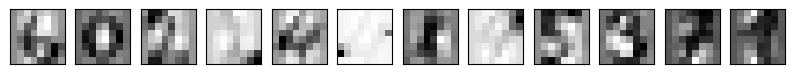

In [12]:
# Функция для отображения центров кластеров
def plot_cluster_centers(centers):
    fig, ax = plt.subplots(1, len(centers), figsize=(10, 3))
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center.reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')

# Визуализация центроидов лучшей кластеризации
plot_cluster_centers(kmeans_best.cluster_centers_)
plt.show()

Ваш вывод тут

Не всегда бывает удобно работать с полной матрицей объект-признак, например, для случая визуализации данных. Можно применить метод уменьшения размерности *PCA*. Вот [здесь](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) было показано сравнение различных способов сжатия размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую картину и одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10) и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить почему?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target
optimal_n_clusters = len(np.unique(y))  # Предположим, что оптимальное количество кластеров известно и равно количеству уникальных цифр

# Функция для оценки качества кластеризации с разными метриками
def evaluate_clustering(labels_true, labels_pred):
    print("Homogeneity:", metrics.homogeneity_score(labels_true, labels_pred))
    print("Completeness:", metrics.completeness_score(labels_true, labels_pred))
    print("Adjusted Rand Index:", metrics.adjusted_rand_score(labels_true, labels_pred))
    print("Silhouette Coefficient:", metrics.silhouette_score(X, labels_pred))

# Применение PCA и tSNE с разным числом компонент
for n_components in [2, 3]:  # Изменил 10 на 3 для tSNE
    print(f"\nEvaluating with {n_components} components...")

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    kmeans_pca = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=10)
    kmeans_pca.fit(X_pca)
    print("\nPCA:")
    evaluate_clustering(y, kmeans_pca.labels_)

    # tSNE - только если n_components меньше или равно 3
    if n_components <= 3:
        tsne = TSNE(n_components=n_components, random_state=42)
        X_tsne = tsne.fit_transform(X)
        kmeans_tsne = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=10)
        kmeans_tsne.fit(X_tsne)
        print("\ntSNE:")
        evaluate_clustering(y, kmeans_tsne.labels_)

Ваш вывод тут

Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить почему так произошло?

In [ ]:
# Поиск индексов объектов, которые были неправильно отнесены во всех случаях
misclustered = np.zeros(len(y), dtype=bool)
for label in np.unique(y):
    # Индексы объектов истинного класса
    indices = (y == label)

    # Большинство кластера для истинного класса в исходной кластеризации
    cluster_label = np.argmax(np.bincount(cluster_labels[indices]))

    # Объекты, которые не соответствуют большинству кластера для истинного класса
    misclustered_indices = (cluster_labels[indices] != cluster_label)

    # Обновляем массив ошибочно отнесенных объектов
    misclustered[indices] = misclustered_indices

# Визуализация ошибочно отнесенных объектов
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[misclustered][i], cmap=plt.cm.gray_r, interpolation='nearest')
    axi.set(xticks=[], yticks=[])

plt.show()

Ваш вывод тут

## Задание 2. Разделение изображения на семантические компоненты (4 балла)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

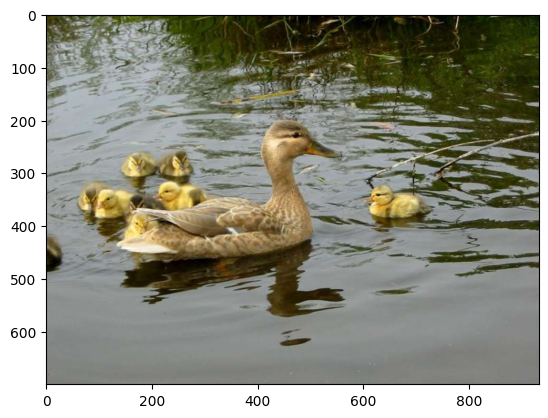

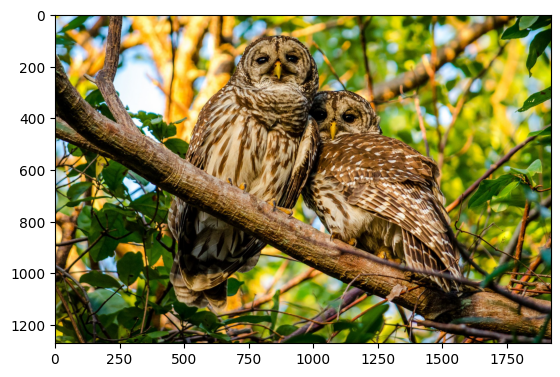

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

image1 = imread("duck.jpg")
plt.imshow(image1)
plt.show()

image2 = imread("owls.jpg")
plt.imshow(image2)
plt.show()



Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


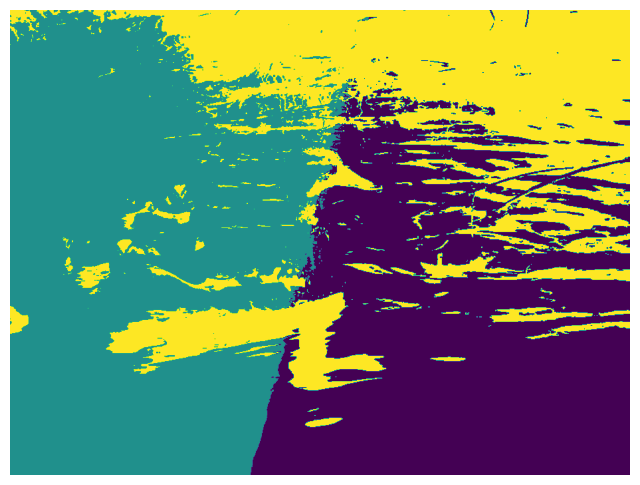

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


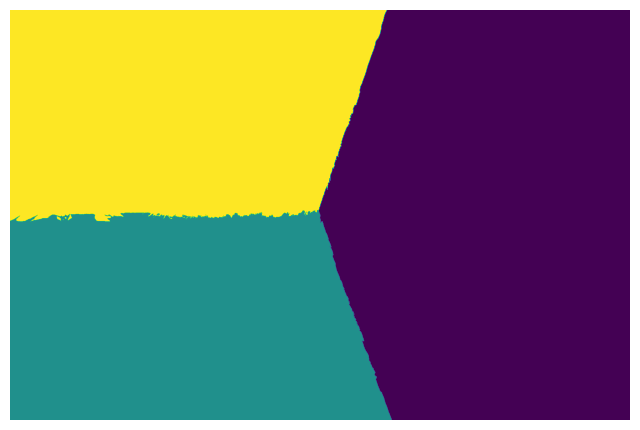

In [4]:
import numpy as np

def find_components(image, lmbd, n_clusters):
 # Получаем размеры изображения
    rows, cols, channels = image.shape

    # Инициализируем массив для хранения признаков пикселей
    pixels_features = np.zeros((rows * cols, channels + 2))

    # Заполняем массив признаками пикселей
    for i in range(rows):
        for j in range(cols):
            r, g, b = image[i, j]
            pixels_features[i * cols + j] = [lmbd * i, lmbd * j, r, g, b]

    # Применяем KMeans для кластеризации пикселей
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels_features)

    # Восстанавливаем изображение после кластеризации
    segmented_image = labels.reshape(rows, cols)

    # Визуализация результата сегментации
    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_image, cmap='viridis')
    plt.axis('off')
    plt.show()

# Применяем функцию к изображениям
find_components(image1, 0.3, 3)
find_components(image2, 1.5, 3)


Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

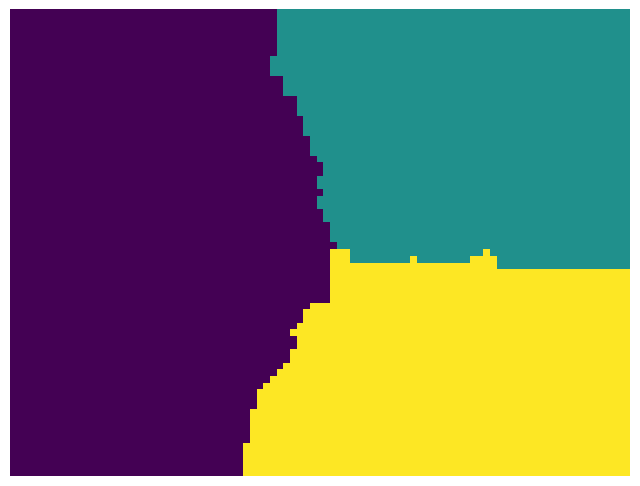

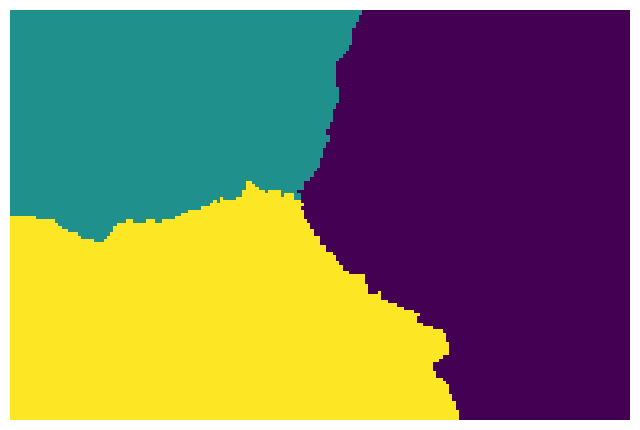

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.transform import resize
from sklearn.feature_extraction import image as sklearn_image
from sklearn.cluster import SpectralClustering

def spectral_segmentation(image_path, n_clusters, resize_factor=0.1):  # Уменьшенный resize_factor
    # Загружаем изображение и приводим его к серому цвету
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)

    # Сжимаем изображение для ускорения обработки
    image_resized = resize(image_gray, (int(image_gray.shape[0] * resize_factor), int(image_gray.shape[1] * resize_factor)), anti_aliasing=True)

    # Преобразуем изображение в граф
    graph = sklearn_image.img_to_graph(image_resized)

    # Применяем экспоненциальное преобразование к весам рёбер графа
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / image_resized.std()) + eps

    # Применяем спектральную кластеризацию
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans', random_state=1)  # Изменено assign_labels
    labels = spectral.fit_predict(graph)

    # Восстанавливаем размер изображения до исходного
    labels = labels.reshape(image_resized.shape)

    # Визуализация результата сегментации
    plt.figure(figsize=(8, 8))
    plt.imshow(labels, cmap='viridis')
    plt.axis('off')
    plt.show()

# Применяем функцию к изображениям
spectral_segmentation("duck.jpg", n_clusters=3)
spectral_segmentation("owls.jpg", n_clusters=3)

Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов.

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


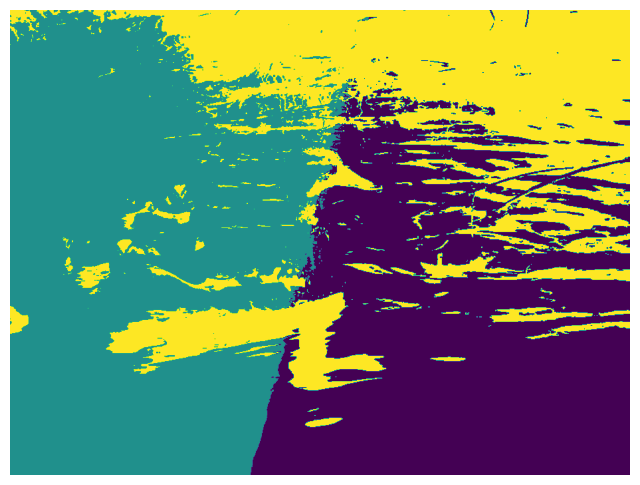

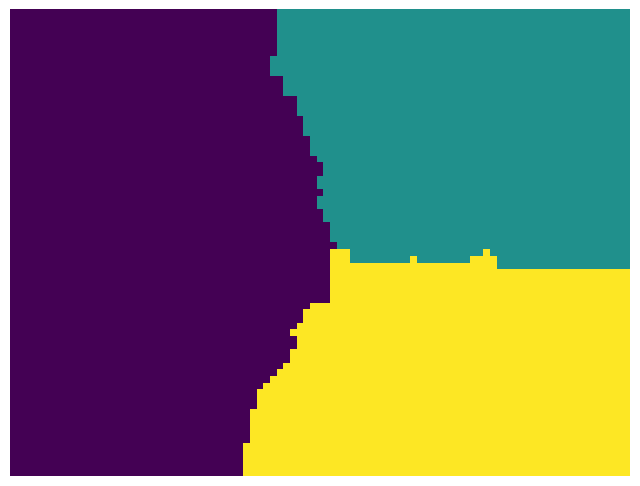

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


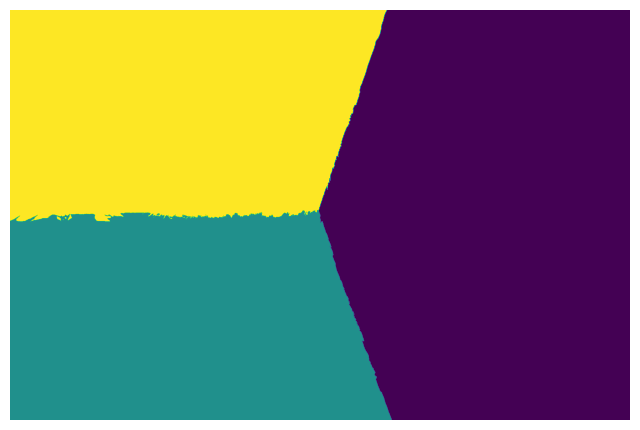

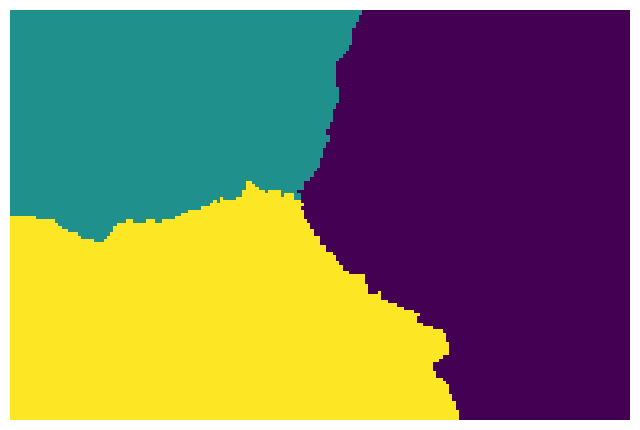

In [6]:
import skimage.io
import skimage.color
import skimage.transform

# Чтение и уменьшение размера изображений
image1 = skimage.io.imread("duck.jpg")
image2 = skimage.io.imread("owls.jpg")

# Перевод в серый цвет и уменьшение размера
image11 = skimage.color.rgb2gray(image1)
rows, cols = image1.shape[0], image1.shape[1]
image11 = skimage.transform.resize(image11, (int(0.5 * rows), int(0.5 * cols)))

image22 = skimage.color.rgb2gray(image2)
rows, cols = image2.shape[0], image2.shape[1]
image22 = skimage.transform.resize(image22, (int(0.5 * rows), int(0.5 * cols)))

# Применяем функции сегментации к уменьшенным серым изображениям
find_components(image1, 0.3, 3)
spectral_segmentation("duck.jpg", n_clusters=3)

find_components(image2, 1.5, 3)
spectral_segmentation("owls.jpg", n_clusters=3)

#your code here

Поэкспериментируйте с параметрами алгоритмов. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


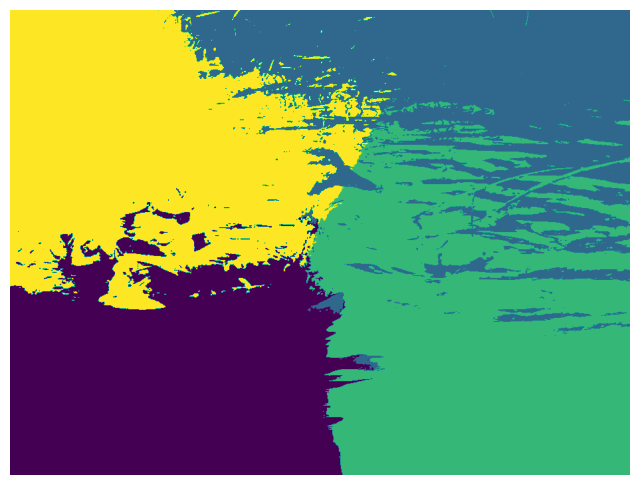

C:\Users\azhoh\PycharmProjects\homeWork2\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


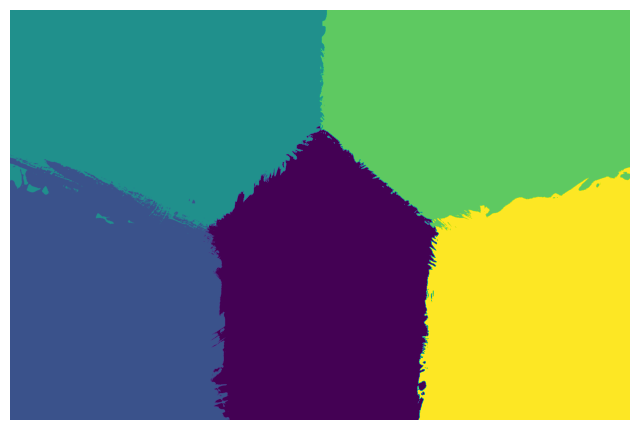

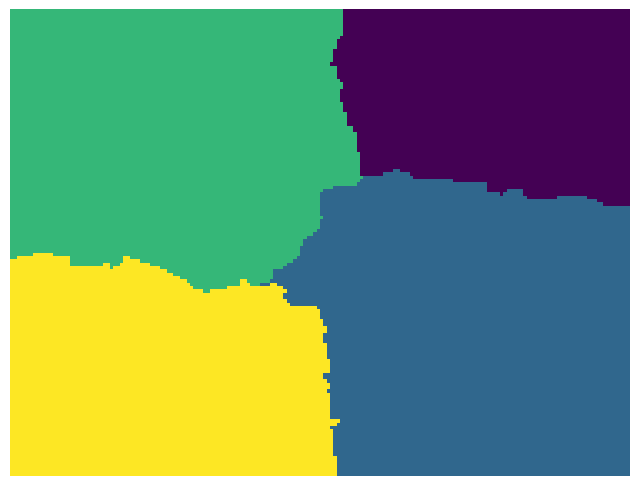

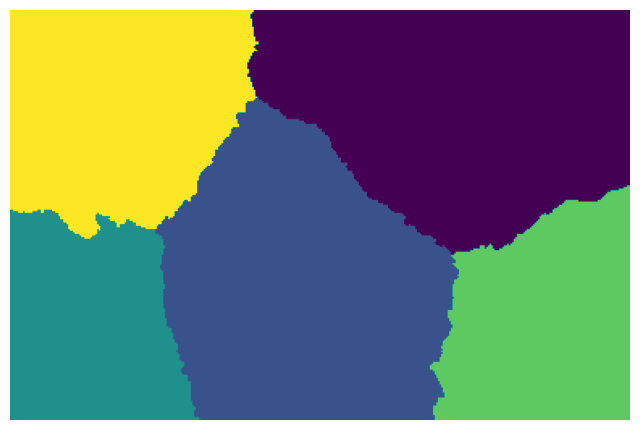

In [7]:
# Экспериментирование с параметрами для KMeans
find_components(image1, 0.5, 4)  # Изменённый параметр lmbd и количество кластеров
find_components(image2, 0.8, 5)

# Экспериментирование с параметрами для спектральной сегментации
spectral_segmentation("duck.jpg", n_clusters=4, resize_factor=0.2)  # Изменённое количество кластеров и resize_factor
spectral_segmentation("owls.jpg", n_clusters=5, resize_factor=0.2)

Ваш вывод тут